# Load Libraries and Datasets

In [1]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.ticker import MaxNLocator, FuncFormatter


def plot_sleep_stages(sdf, rows_per_epoch):
    """
    Plots sleep stages, raw BVP signal, and accelerometer magnitude over time in a three-panel vertical plot.

    Parameters:
    sdf (DataFrame): DataFrame containing the columns 'TIMESTAMP', 'ECG', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', and 'Sleep_Stage'
    rows_per_epoch (int): Number of rows representing each 30-second epoch

    """
    # Aggregate the data to one row per epoch for sleep stages
    sdf["epoch"] = sdf.index // rows_per_epoch
    epoch_df = sdf.groupby("epoch").first().reset_index()

    # Map Sleep_Stage to numeric values, with N1, N2, and N3 all mapped to the same value "N"
    sleep_stage_mapping = {"W": 0, "N1": 1, "N2": 1, "N3": 1, "R": 2}
    epoch_df["Sleep_Stage_Num"] = epoch_df["Sleep_Stage"].map(sleep_stage_mapping)

    # Calculate the magnitude of the accelerometer signal
    sdf["Acc_Magnitude"] = np.sqrt(
        sdf["ACC_X"] ** 2 + sdf["ACC_Y"] ** 2 + sdf["ACC_Z"] ** 2
    )

    # Plotting
    fig, axes = plt.subplots(
        3, 1, figsize=(12, 6), sharex=True
    )  # Reduce height by 3-fold

    # Panel 1: Sleep stages
    axes[0].scatter(
        epoch_df["TIMESTAMP"],
        epoch_df["Sleep_Stage_Num"],
        c=epoch_df["Sleep_Stage_Num"],
        cmap="viridis",
        label="Sleep Stage",
        s=10,  # Smaller marker size
    )
    axes[0].set_ylabel("Sleep Stage")
    axes[0].set_yticks([0, 1, 2])
    axes[0].set_yticklabels(["W", "N", "R"])  # Custom y-tick labels
    axes[0].grid(True)
    axes[0].set_title("Sleep Stages Over Time")
    axes[0].legend()

    # Panel 2: Raw BVP signal in salmon color
    axes[1].plot(sdf["TIMESTAMP"], sdf["BVP"], color="salmon")  # Salmon color

    # Highlighting extreme values in bright red
    extreme_indices = (sdf["BVP"] > 500) | (sdf["BVP"] < -500)
    axes[1].plot(
        sdf["TIMESTAMP"][extreme_indices],
        sdf["BVP"][extreme_indices],
        "ro",
        markersize=4,
    )  # Smaller marker size for extremes

    # Add horizontal thresholds at 500 and -500
    axes[1].axhline(500, color="black", linestyle="--", linewidth=1)
    axes[1].axhline(-500, color="black", linestyle="--", linewidth=1)

    axes[1].set_ylabel("BVP Signal")
    axes[1].grid(True)
    axes[1].set_title("Raw BVP Signal Over Time")

    # Panel 3: Accelerometer magnitude in gray
    axes[2].plot(sdf["TIMESTAMP"], sdf["Acc_Magnitude"], color="gray")  # Gray color
    axes[2].set_ylabel("Acc Magnitude")
    axes[2].grid(True)
    axes[2].set_title("Accelerometer Magnitude Over Time")

    # Common x-axis label
    axes[2].set_xlabel("Timestamp")

    plt.tight_layout()
    plt.show()


# Function to find all valid 10-second segments within 30-second epochs
def find_all_valid_segments(df, sleep_stage, fs, segment_length=10, epoch_length=30):
    stage_df = df[df["Sleep_Stage"] == sleep_stage].reset_index(drop=True)
    num_epochs = len(stage_df) // (epoch_length * fs)
    segment_samples = segment_length * fs
    epoch_samples = epoch_length * fs
    valid_starts = []

    for e in range(num_epochs):
        start = e * epoch_samples
        epoch = stage_df.iloc[start : start + epoch_samples].reset_index(drop=True)
        valid_starts.append(epoch.iloc[0, 0])
        valid_starts.append(epoch.iloc[10 * fs, 0])
        valid_starts.append(epoch.iloc[20 * fs, 0])

    print(len(valid_starts))
    return valid_starts, segment_samples


# Function to select random segments from valid starts
def select_random_segments(valid_starts, num_segments=9):
    if len(valid_starts) < num_segments:
        raise ValueError("Not enough valid segments available.")

    selected_starts = random.sample(valid_starts, num_segments)
    return selected_starts


# Function to get segments based on start indices
def get_segments(df, start_times, segment_samples):
    start_indices = [
        df.loc[df["TIMESTAMP"] == start_time, :].index[0] for start_time in start_times
    ]
    segments = [df.iloc[start : start + segment_samples] for start in start_indices]
    return segments


# Function to plot the segments in a 3x3 grid
def plot_segments(segments, fs, sleep_stage):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    fig.suptitle(
        f"Random 10-second segments for sleep stage {sleep_stage}", fontsize=16
    )

    def integer_formatter(x, pos):
        return f"{int(x)}"

    for i, segment in enumerate(segments):
        ax = axes[i // 3, i % 3]
        # Change to ECG when needed
        ax.plot(segment["TIMESTAMP"], segment["BVP"])
        ax.set_title(f"Segment {i+1}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("BVP")
        # ax.set_ylim([-0.00060, 0.00060])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_formatter(FuncFormatter(integer_formatter))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


ECG_data_path = "/media/nvme1/sleep/DREAMT_Version2/PSG_dataframes/"

list_dir = os.listdir(ECG_data_path)

list_files = [os.path.join(ECG_data_path, i) for i in list_dir if i.endswith(".csv")]
list_files.sort()

# Visualize raw data

In [58]:
for i in range(100):
    sdf = pd.read_csv(list_files[i])
    sdf = sdf.loc[
        :, ["TIMESTAMP", "ECG", "BVP", "ACC_X", "ACC_Y", "ACC_Z", "Sleep_Stage"]
    ]
    if sdf["Sleep_Stage"].tolist()[0] != 'W':
        print(list_files[i])

/media/nvme1/sleep/DREAMT_Version2/PSG_dataframes/S042_PSG_df.csv


/media/nvme1/sleep/DREAMT_Version2/PSG_dataframes/S042_PSG_df.csv
Sleep_Stage
N2    1659000
R      372000
N1     153000
W       99000
N3      39000
Name: count, dtype: int64
100


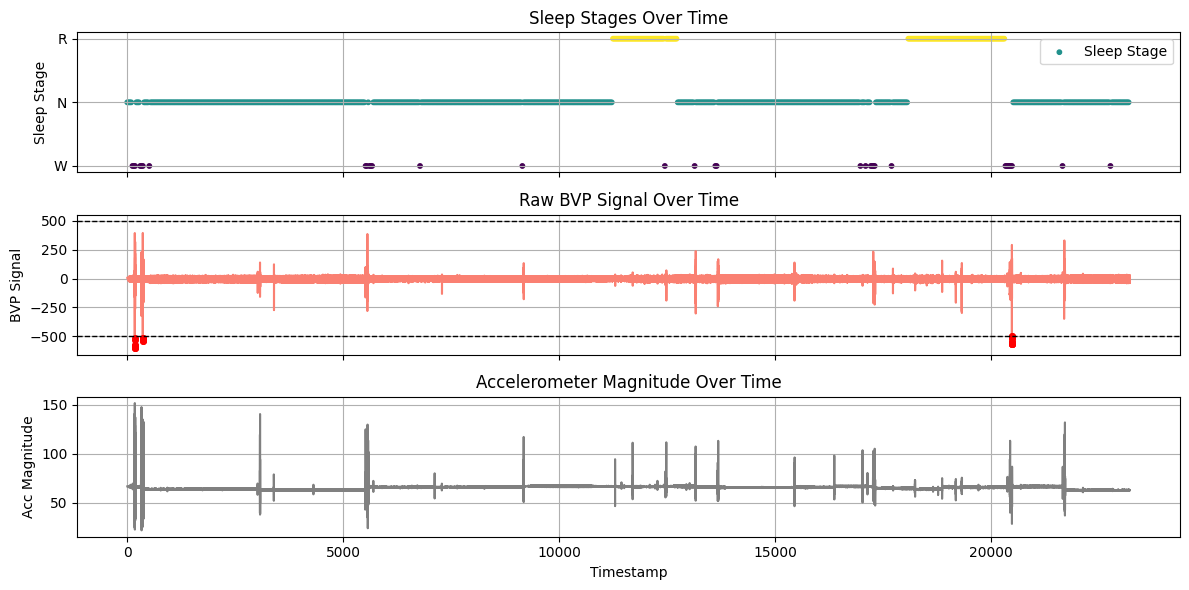

In [59]:
i = 39
sdf = pd.read_csv(list_files[i])
print(list_files[i])
sdf = sdf.loc[:, ["TIMESTAMP", "ECG","BVP","ACC_X","ACC_Y","ACC_Z","Sleep_Stage"]]
print(sdf.Sleep_Stage.value_counts())
# Determine the frequency of TIMESTAMP
timestamp_frequency = int(1 / (sdf.iloc[1, 0] - sdf.iloc[0, 0]))
print(timestamp_frequency)
epoch_length = 30  # in seconds
rows_per_epoch = epoch_length * timestamp_frequency
plot_sleep_stages(sdf, rows_per_epoch=rows_per_epoch)

Some problems with S046

1221


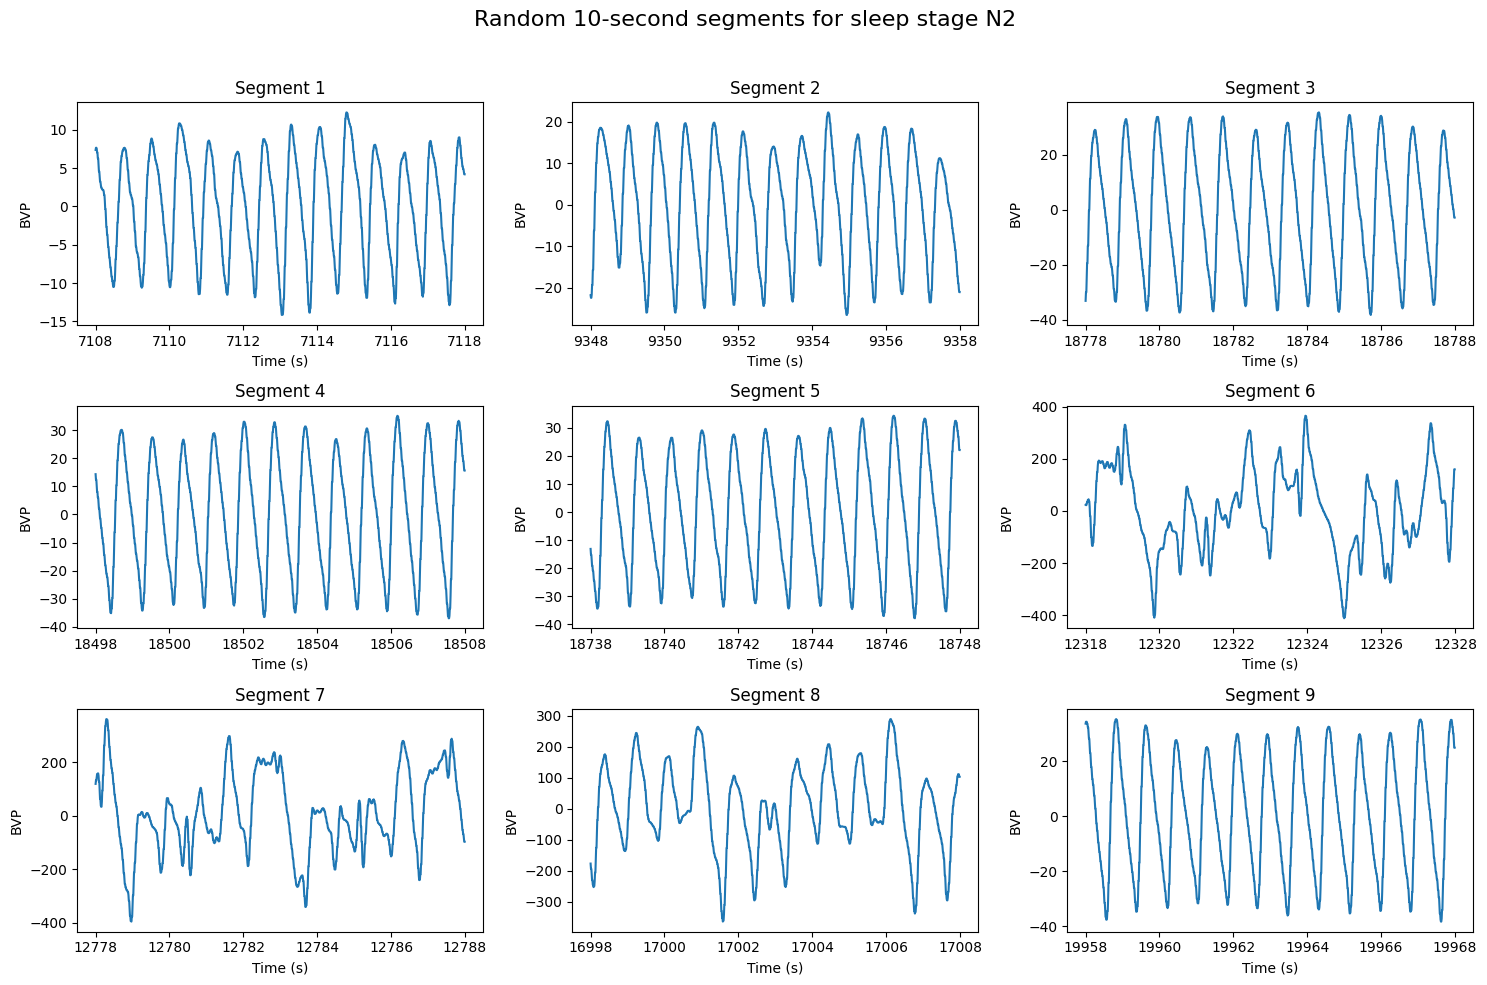

In [20]:
# Example usage
fs = timestamp_frequency  # or 500, based on your actual data
sleep_stage = "N2"  # or 'N1', 'N2', 'N3', 'R'
num_segments = 9

# Assume df is your DataFrame loaded with ["TIMESTAMP", "ECG", "Sleep_Stage"]
# df = pd.read_csv('your_data.csv')

valid_starts, segment_samples = find_all_valid_segments(sdf, sleep_stage, fs)
selected_starts = select_random_segments(valid_starts, num_segments=num_segments)
segments = get_segments(sdf, selected_starts, segment_samples)
plot_segments(segments, fs, sleep_stage)

# Visualize IBI

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mesa_exp_dir = "/mnt/nvme2/MESA_PIBI/mesa-0393.npz"
mesa_data = np.load(mesa_exp_dir)
print(mesa_data["fs"])

shhs_exp_dir = "/media/nvme1/sleep/ECG/SHHS_IBI/shhs1-203396.npz"
shhs_data = np.load(shhs_exp_dir)
print(shhs_data["fs"])

25
25


In [8]:
mesa_data["data"].max()

1.992

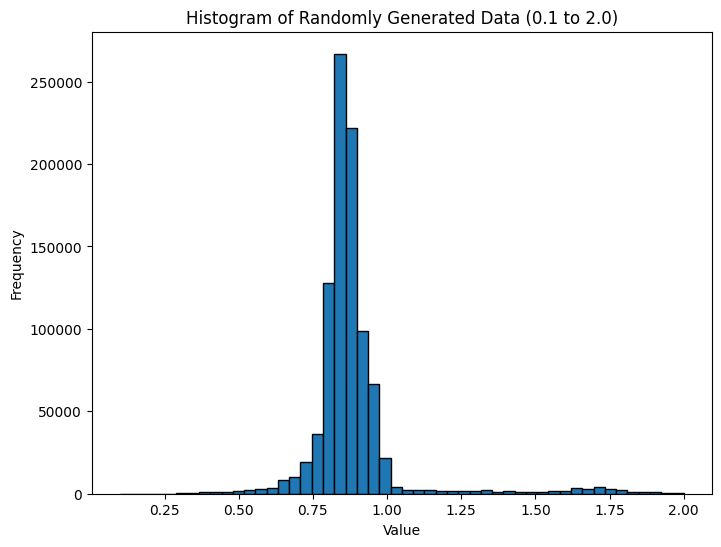

In [9]:
data = mesa_data["data"]

data = data[(data >= 0.1) & (data <= 2.0)]

# Create the histogram with more bins
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, edgecolor="black", range=(0.1, 2.0))

# Add titles and labels
plt.title("Histogram of Randomly Generated Data (0.1 to 2.0)")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plot
plt.show()